## 1. Imports


In [1]:
import os
import sys
import gc
import warnings

import torch
import torchvision
import matplotlib.pyplot as plt

from torchvision.transforms import Compose, ToTensor, Resize, Normalize, Lambda
from PIL import PngImagePlugin

from IPython.display import clear_output

sys.path.append("..")
from src.unet import UNet
from src.mnistm_utils import MNISTM
from src.tools import (
    set_random_seed,
    get_loader_stats,
    get_pushed_loader_stats,
    get_pushed_loader_accuracy
)
from src.plotters import (
    plot_pushed_images,
    plot_pushed_random_class_images,
)
from src.samplers import (
    SubsetGuidedSampler,
    SubsetGuidedDataset,
    get_indicies_subset,
)

LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

warnings.filterwarnings("ignore")

%matplotlib inline 

In [2]:
gc.collect()
torch.cuda.empty_cache()


## 2. Init Config

the config file `config.json` is saved at saved_models/EXP_NAME/



In [12]:
SEED = 0x3060
set_random_seed(SEED)

# dataset choosing
DATASET, DATASET_PATH, CLASS = "fmnist2mnist", "../datasets/", 4 # OR 6
# DATASET, DATASET_PATH, CLASS = "mnist2fmnist", "../datasets/", 4 # OR 6
# DATASET, DATASET_PATH, CLASS = "mnist2usps", "../datasets/", 3 # OR 9
# DATASET, DATASET_PATH, CLASS = "usps2mnist", "../datasets/", 3 # OR 9

IMG_SIZE = 32
DATASET1_CHANNELS = 1
DATASET2_CHANNELS = 1

# GPU choosing
DEVICE_IDS = [1]
assert torch.cuda.is_available()
torch.cuda.set_device(f"cuda:{DEVICE_IDS[0]}")

# All hyperparameters below is set to the values used for the experiments, which discribed in the article

# training algorithm settings
BATCH_SIZE = 32
SUBSET_SIZE = 2
NUM_LABELED = 10  # num of labeled target in training set

COST = "Energy"
MAX_STEPS = 30000 + 1
# plot settings
GRAY_PLOTS = True

FID_EPOCHS = 1


In [ ]:
LOAD_PATH = "path/to/weights"

if not os.path.exists(LOAD_PATH):
    raise Exception("there is no such file or directory...")

In [4]:
source_subset = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
new_labels_source = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
target_subset = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
new_labels_target = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


In [6]:
classifier = torchvision.models.resnet18()
classifier.conv1 = torch.nn.Conv2d(
    1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
)
classifier.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True)

source_transform = Compose(
    [
        Resize((IMG_SIZE, IMG_SIZE)),
        ToTensor(),
        Normalize((0.5), (0.5)),
    ]
)
target_transform = source_transform

if DATASET == "mnist2fmnist":
    target = torchvision.datasets.FashionMNIST
    source = torchvision.datasets.MNIST

    classifier.load_state_dict(torch.load("../saved_models/classifiers/fmnist.pt"))

elif DATASET == "fmnist2mnist":
    source = torchvision.datasets.FashionMNIST
    target = torchvision.datasets.MNIST

    classifier.load_state_dict(torch.load("../saved_models/classifiers/mnist.pt"))

elif DATASET == "mnist2usps":
    source = torchvision.datasets.MNIST
    target = torchvision.datasets.USPS

    classifier.load_state_dict(torch.load("../saved_models/classifiers/usps.pt"))

elif DATASET == "usps2mnist":
    target = torchvision.datasets.MNIST
    source = torchvision.datasets.USPS

    classifier.load_state_dict(torch.load("../saved_models/classifiers/mnist.pt"))

classifier.cuda()
classifier.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 3. Initialize samplers


In [7]:
source_test = source(
    root=DATASET_PATH, train=False, download=True, transform=source_transform
)
source_subset_samples, source_labels, source_class_indicies = get_indicies_subset(
    source_test,
    new_labels=new_labels_source,
    classes=len(source_subset),
    subset_classes=source_subset,
)
source_test = torch.utils.data.TensorDataset(
    torch.stack(source_subset_samples), torch.LongTensor(source_labels)
)


target_test = target(
    root=DATASET_PATH, train=False, download=True, transform=target_transform
)
target_subset_samples, target_labels, target_class_indicies = get_indicies_subset(
    target_test,
    new_labels=new_labels_target,
    classes=len(target_subset),
    subset_classes=target_subset,
)
target_test = torch.utils.data.TensorDataset(
    torch.stack(target_subset_samples), torch.LongTensor(target_labels)
)

full_set_test = SubsetGuidedDataset(
    source_test,
    target_test,
    num_labeled="all",
    in_indicies=source_class_indicies,
    out_indicies=target_class_indicies,
)

SUBSET_WEIGHTS = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SUBSET_WEIGHTS[CLASS] = 1.0

XY_test_sampler = SubsetGuidedSampler(full_set_test, subsetsize=1, weight=SUBSET_WEIGHTS)

X_test_loader = torch.utils.data.DataLoader(
    source_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

Y_test_loader = torch.utils.data.DataLoader(
    target_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

# TODO: make X, Y be 1 class dataloader

In [8]:
torch.cuda.empty_cache()
gc.collect()
clear_output()

## 4. Testing

### init models



In [9]:
T = UNet(DATASET1_CHANNELS, DATASET2_CHANNELS, base_factor=48).cuda()

### Load weights for continue training

In [13]:
print("Loading weights")

w_path = os.path.join(LOAD_PATH)  # user setting

T.load_state_dict(torch.load(w_path))
print(f"{w_path}, loaded")

Loading weights
../saved_models/GNOT_Class_fmnist2mnist_12384/ T_12384_30000.pt, loaded


### Plots Test


In [14]:
X_test_fixed, Y_test_fixed = XY_test_sampler.sample(10)
X_test_fixed, Y_test_fixed = X_test_fixed.flatten(0, 1), Y_test_fixed.flatten(0, 1)

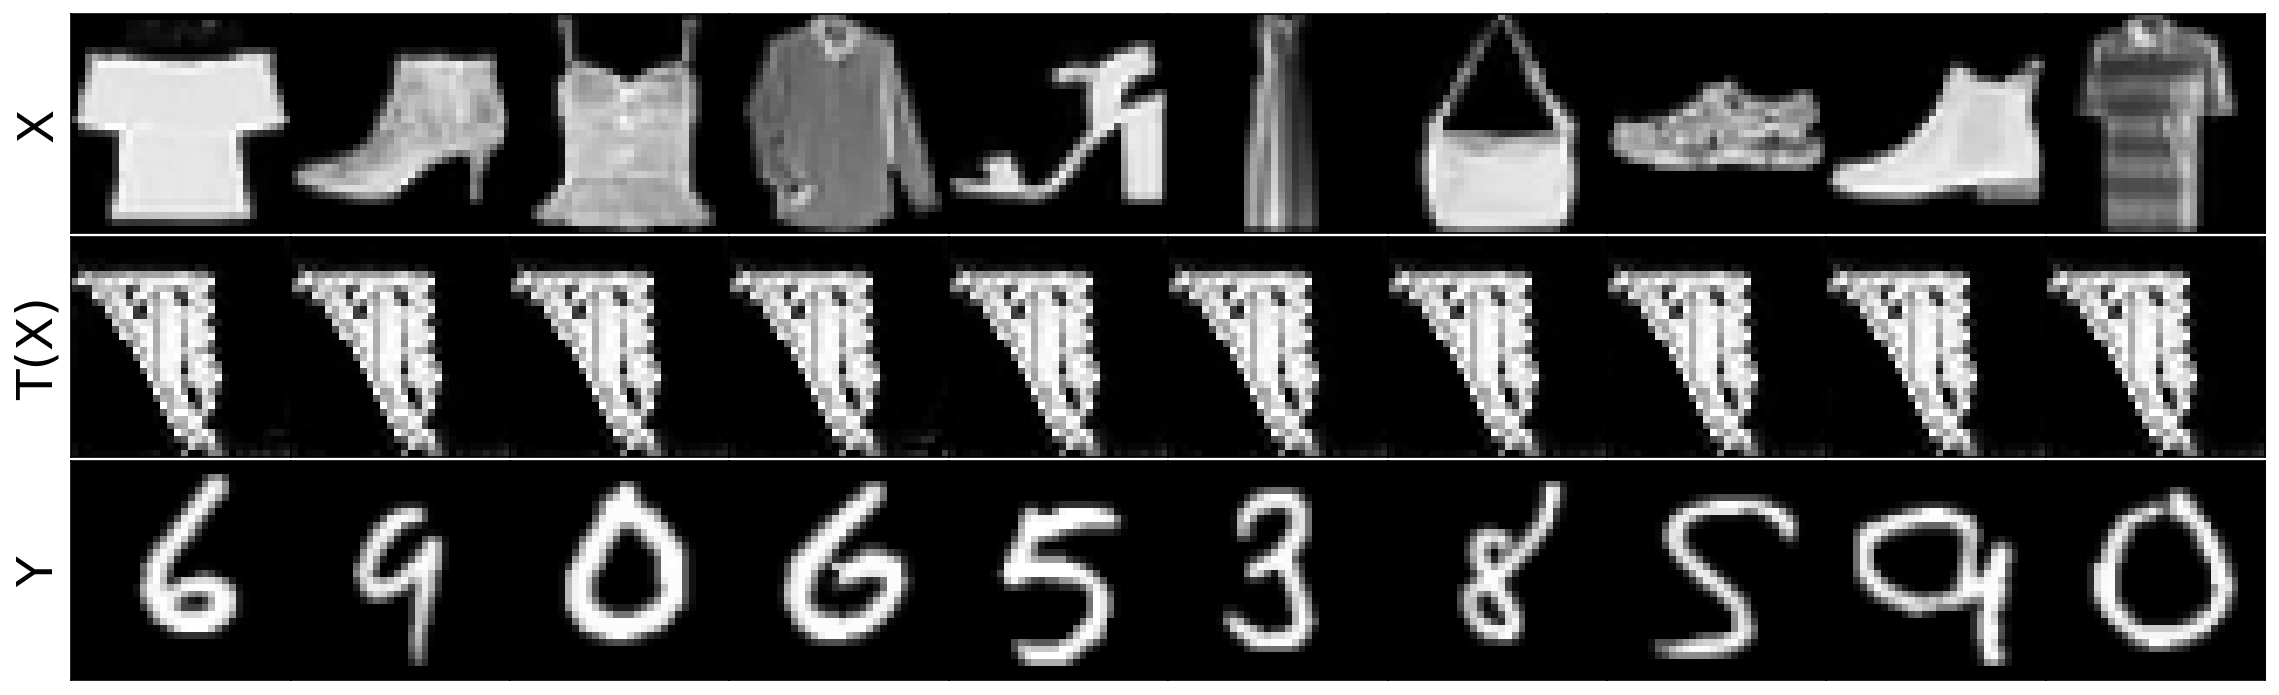

In [15]:
fig, axes = plot_pushed_images(X_test_fixed, Y_test_fixed, T, gray=GRAY_PLOTS)

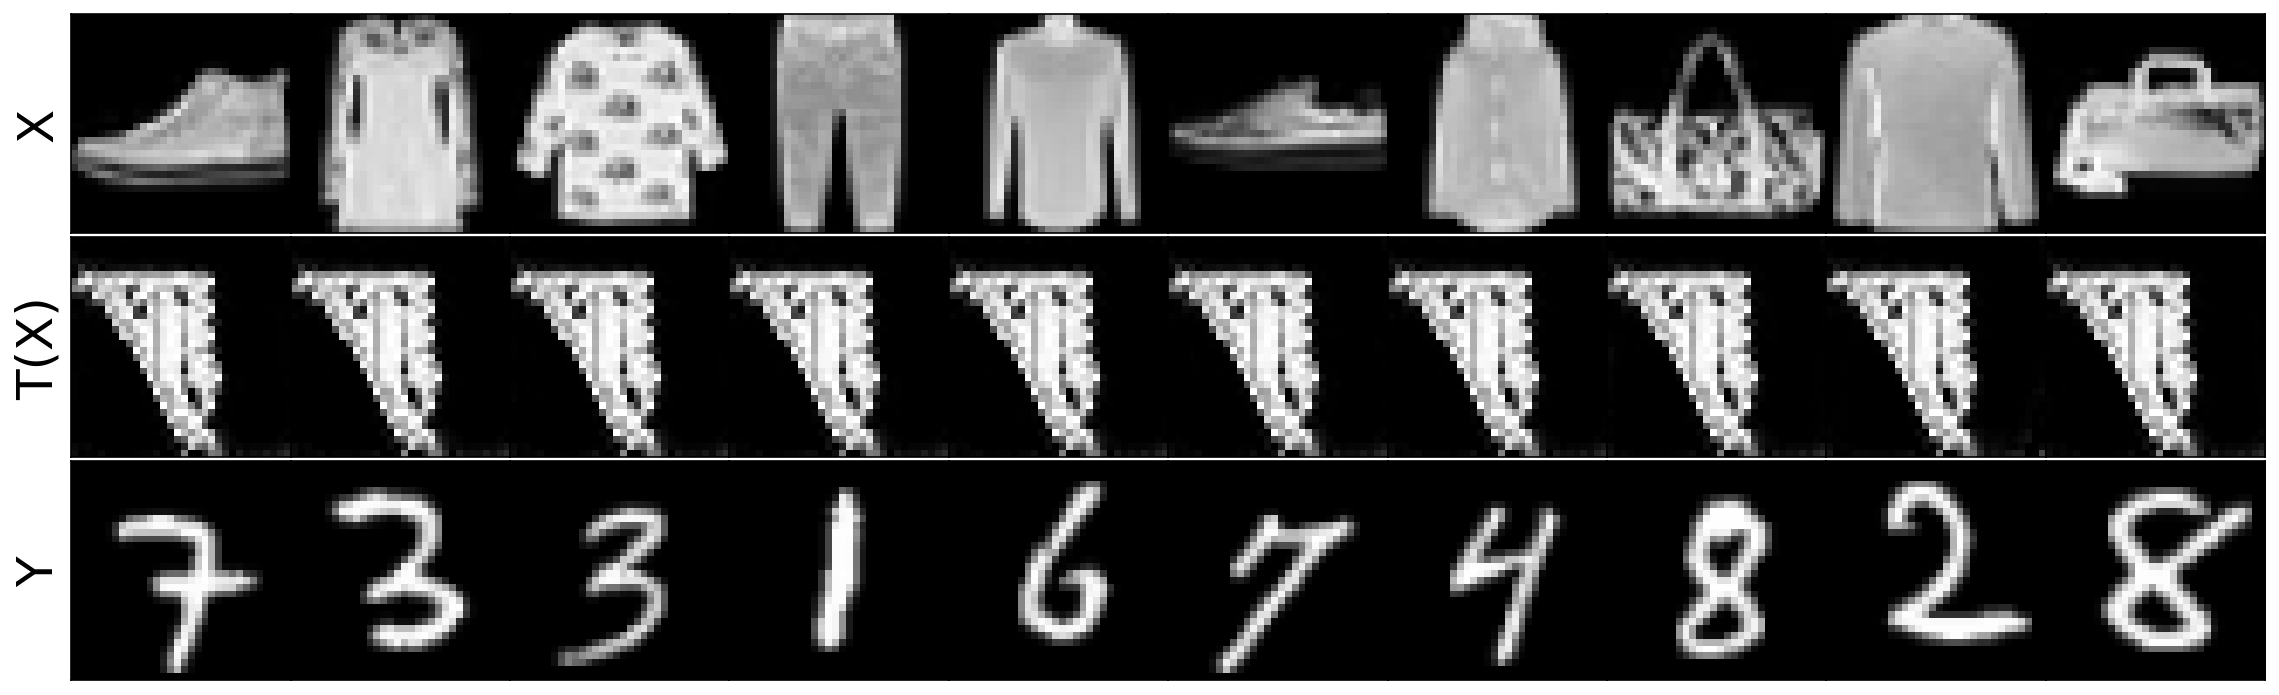

In [16]:
fig, axes = plot_pushed_random_class_images(
    XY_test_sampler, T, gray=GRAY_PLOTS
)

## Plot paper using images

In [ ]:
# TODO

### main testing


Plotting
Fixed Test Images


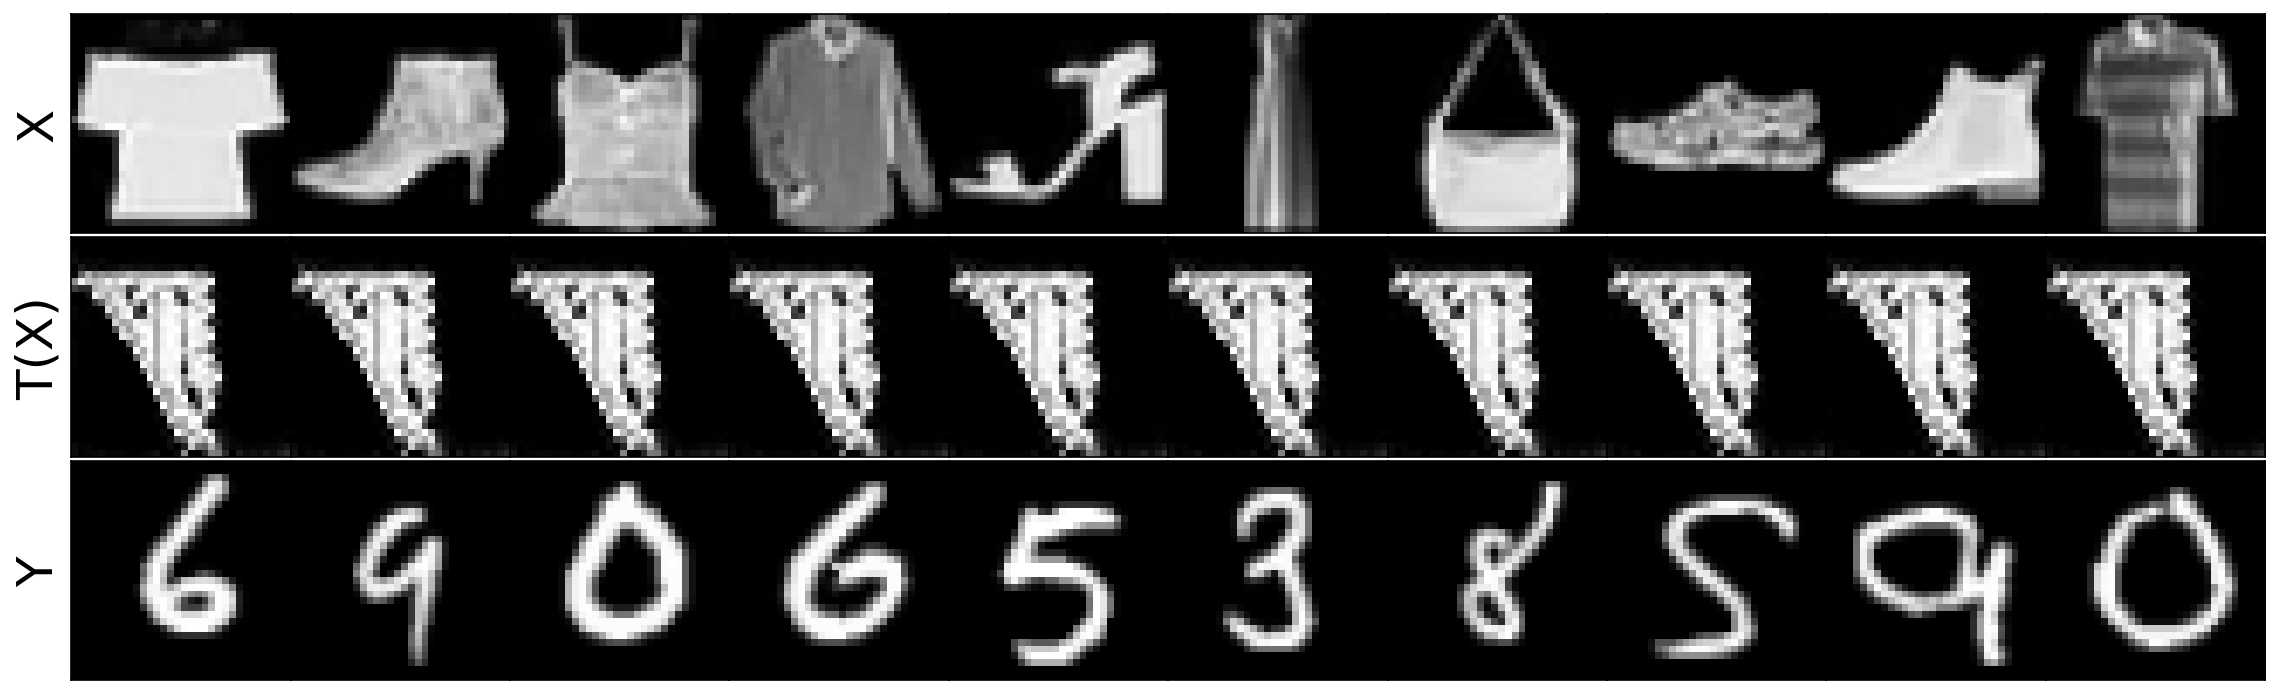

Random Test Images


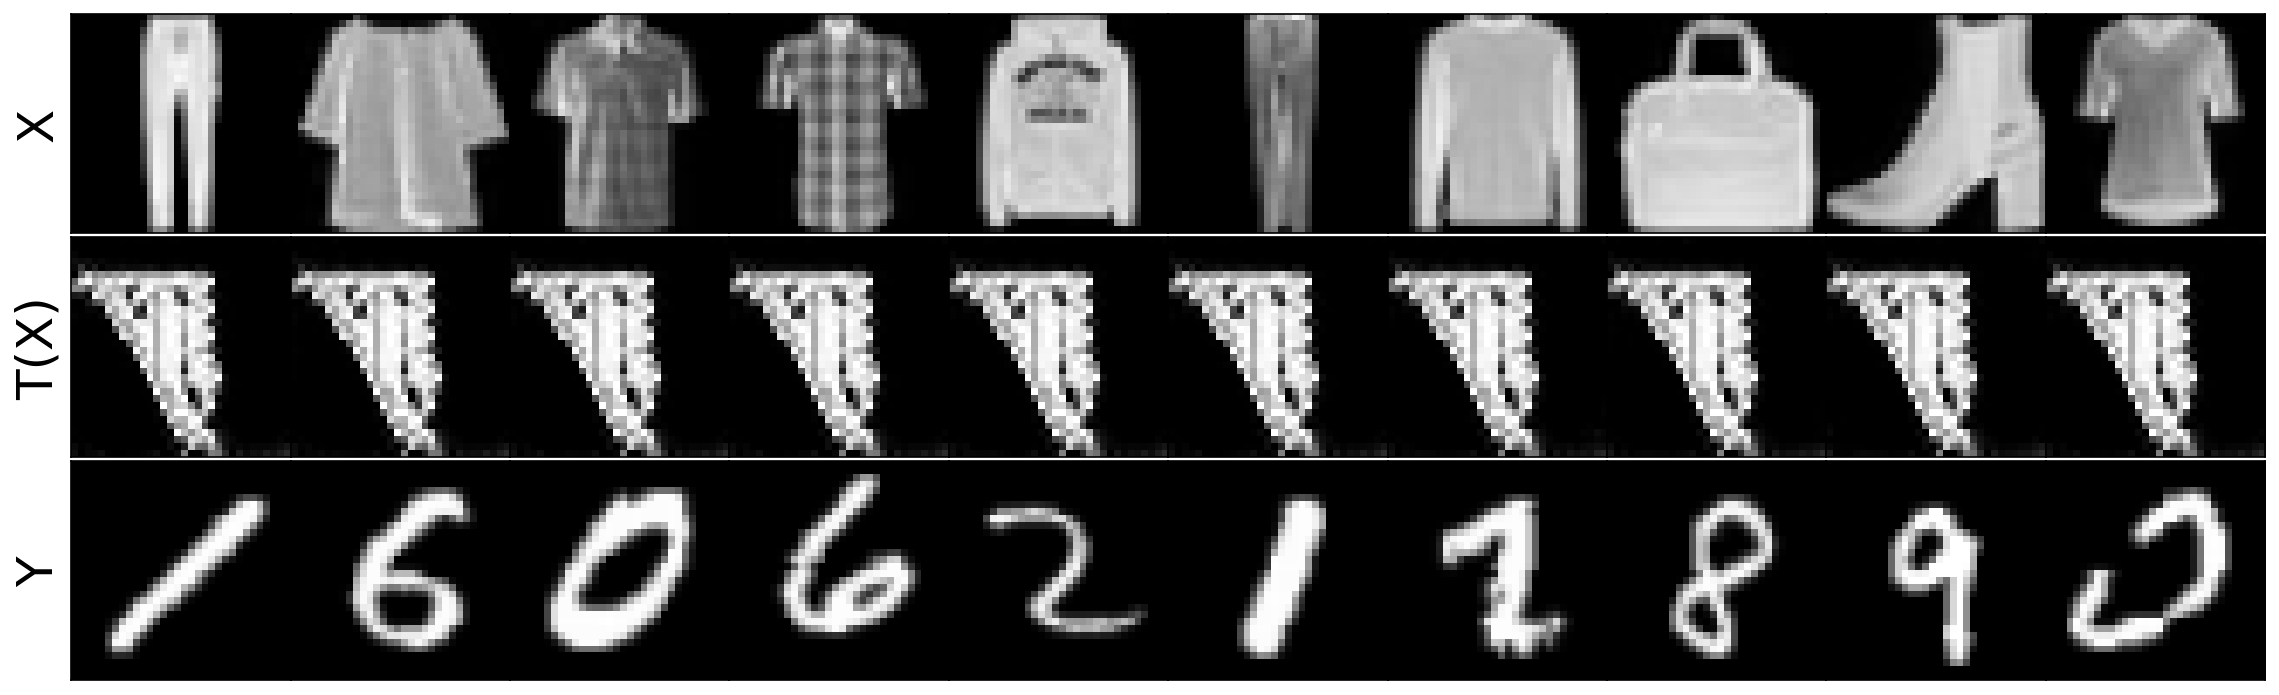

In [17]:
clear_output(wait=True)
print("Plotting")

inference_T = T
inference_T.eval()
print("Fixed Test Images")
fig, axes = plot_pushed_images(X_test_fixed, Y_test_fixed, inference_T, gray=GRAY_PLOTS)
# wandb.log({"Fixed Images": [wandb.Image(fig2img(fig))]}, step=step)
plt.show(fig)
plt.close(fig)
print("Random Test Images")
fig, axes = plot_pushed_random_class_images(
    XY_test_sampler, inference_T, gray=GRAY_PLOTS
)
# wandb.log({"Random Images": [wandb.Image(fig2img(fig))]}, step=step)
plt.show(fig)
plt.close(fig)

In [18]:
from src.fid_score import calculate_frechet_distance


print("Computing FID")

target_mu, target_sigma = get_loader_stats(
    Y_test_loader, BATCH_SIZE, FID_EPOCHS, verbose=True, use_Y=False
)

gen_mu, gen_sigma = get_pushed_loader_stats(
    T,
    X_test_loader,
    n_epochs=FID_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=True,
)
fid = calculate_frechet_distance(gen_mu, gen_sigma, target_mu, target_sigma)
print(f"FID={fid}")

Computing FID


'Epoch 1/1: Processing batch 313/313'

'Epoch 1/1: Processing batch 313/313'

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


FID=272.68082558974146


In [ ]:
print("Computing Accuracy")
accuracy = get_pushed_loader_accuracy(T, X_test_loader, classifier)

In [ ]:
# print("Computing Metrics")
# metrics = get_sde_pushed_loader_metrics(
#     T,
#     XY_test_sampler.loader,
#     n_epochs=FID_EPOCHS,
#     verbose=True,
#     log_metrics=["LPIPS", "PSNR", "SSIM", "MSE", "MAE"]
# )
# print(f"metrics={metrics}")